Neuron demo

In [1]:
import torch
import snntorch as snn
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir, Ridge
from collections import namedtuple
from utils.utils import reservoir_dict_to_str, plot_results, reservoir_dict_to_int, plot_reservoir_data, plot_reservoir_activations, plot_reservoir_predictions

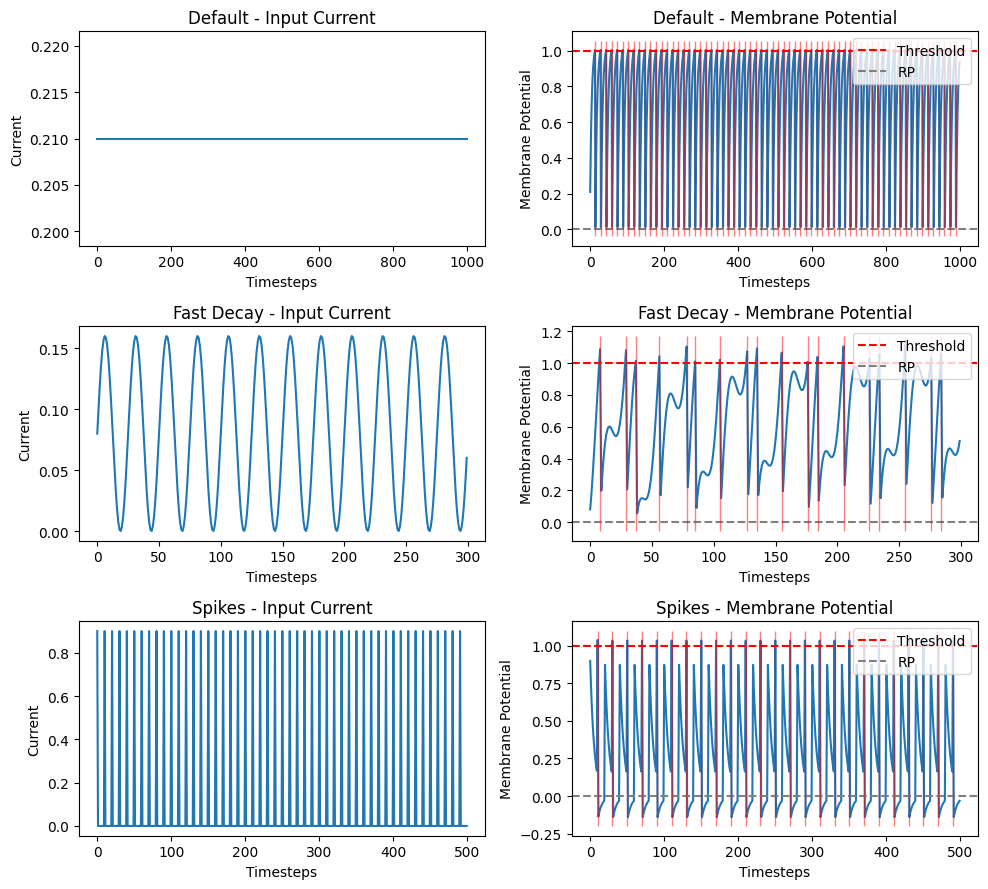

In [2]:
def generate_input(params):
    time = torch.arange(0, params.steps, 1)
    if params.input_type == "sinusoidal":
        sin_strength = params.strength / 2
        input_current = (
            sin_strength * torch.sin(2 * torch.pi * params.frequency * time)
            + sin_strength
        )
    elif params.input_type == "continuous":
        input_current = params.strength * torch.ones_like(time, dtype=torch.float32)
    elif params.input_type == "spiking":
        input_current = torch.zeros_like(time, dtype=torch.float32)

        # Calculate spike interval in steps (how many time steps between spikes)
        spike_interval = int(1 / params.frequency)

        # Set the spike values at the appropriate intervals
        for i in range(0, params.steps, spike_interval):
            input_current[i] = params.strength
    else:
        raise ValueError(
            "Invalid input_type. Choose 'sinusoidal', 'continuous' or 'spiking'."
        )
    zero_percentage = params.steps // 10
    #input_current[:zero_percentage] = 0
    #input_current[-zero_percentage:] = 0
    return time, input_current


def run_simulation(params):
    # Create the LIF neuron using snntorch
    neuron = snn.Leaky(
        beta=params.beta,
        threshold=params.v_threshold,
        reset_mechanism="subtract",
    )

    time, input_current = generate_input(params)

    membrane_potential = torch.zeros_like(time, dtype=torch.float32)
    spikes = torch.zeros_like(time, dtype=torch.float32)
    neuron.reset_mem()
    for i in range(len(time)):
        spk, mem = neuron(input_current[i])
        membrane_potential[i] = mem
        spikes[i] = spk

    return time, input_current, membrane_potential, spikes

# Define a named tuple for parameters
SimParams = namedtuple(
    "SimParams",
    [
        "beta",
        "v_threshold",
        "v_reset",
        "duration",
        "dt",
        "steps",
        "frequency",
        "strength",
        "input_type",
    ],
)

# Create a dictionary of parameter sets
param_sets = {
    "Default": SimParams(
        beta=0.8,
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=1000,
        frequency=0.1,
        strength=0.21,
        input_type="continuous",
    ),
    "Fast Decay": SimParams(
        beta=0.97,
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=300,
        frequency=0.04,
        strength=0.16,
        input_type="sinusoidal",
    ),
    "Spikes": SimParams(
        beta=0.83,
        v_threshold=1,
        v_reset=0.0,
        duration=10.0,
        dt=0.1,
        steps=500,
        frequency=0.1,
        strength=0.9,
        input_type="spiking",
    ),
    # "Spikes2": SimParams(beta=0.85, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, steps=30, frequency=1, strength=0.21, input_type="spiking"),
    # "Slow Decay": SimParams(tau_m=20.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.1, strength=1.0, input_type="sinusoidal"),
    # "High Frequency": SimParams(tau_m=10.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.5, strength=1.0, input_type="sinusoidal"),
}

# Run simulations and store results
results = {}
for label, params in param_sets.items():
    results[label] = run_simulation(params)
# Plot the results
plot_results(results, param_sets)

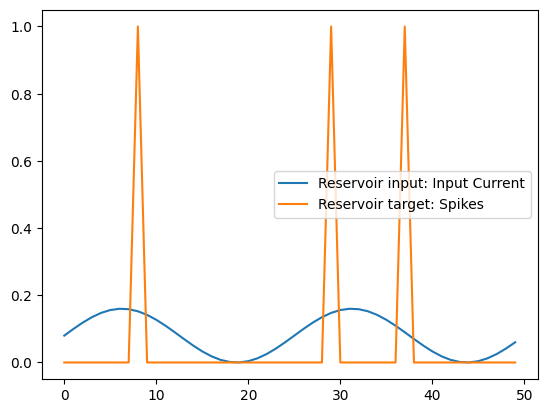

In [3]:
param_set = "Fast Decay" # Options: The labels of the param_sets dictionary, e.g. "Default", "Fast Decay", "Spikes", or any custom ones you have created
reservoir_input_feature = "Input Current" # Options: "Timesteps", "Input Current", "Membrane Potential", "Spikes"
reservoir_target = "Spikes" # Options: "Timesteps", "Input Current", "Membrane Potential", "Spikes"

x_train = results[param_set][reservoir_dict_to_int(reservoir_input_feature)].numpy().reshape(-1, 1)
y_train = results[param_set][reservoir_dict_to_int(reservoir_target)].numpy().reshape(-1, 1)

plot_reservoir_data(x_train, y_train, reservoir_input_feature, reservoir_target)

Running Reservoir-0: 100%|██████████| 50/50 [00:00<00:00, 8325.00it/s]


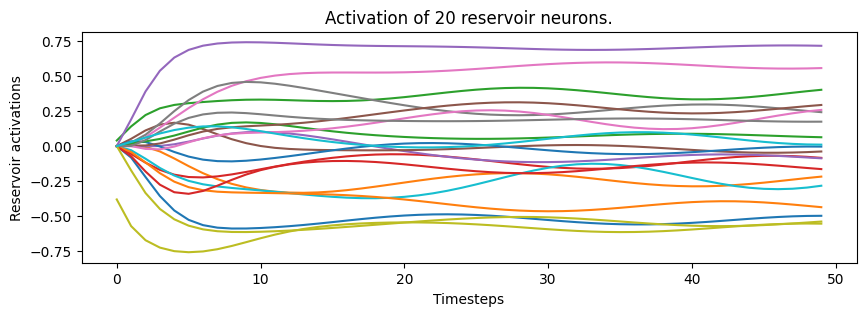

In [4]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
reservoir_states = reservoir.run(x_train[:50])

plot_reservoir_activations(reservoir_states)

In [5]:
reservoir = Reservoir(200, lr=0.6, sr=0.9)
readout = Ridge(ridge=1e-7)

reservoir_model = reservoir >> readout

reservoir_model.fit(x_train, y_train, warmup=10)

Running Model-0: 300it [00:00, 8100.76it/s]           
Running Model-0: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


Fitting node Ridge-0...


'Model-0': Model('Reservoir-1', 'Ridge-0')

Running Model-0: 70it [00:00, 6993.34it/s]            


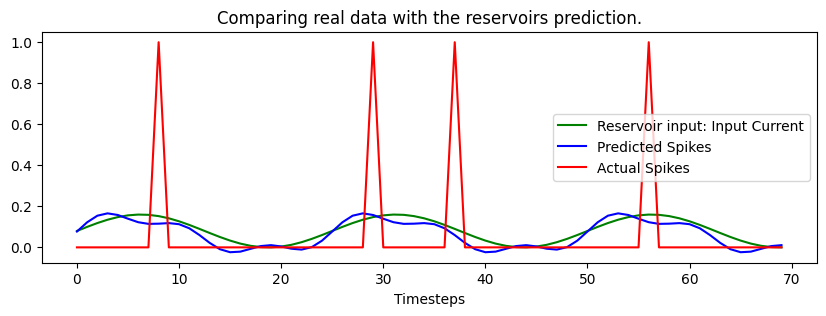

In [6]:
y_pred = reservoir_model.run(x_train[:70])

plot_reservoir_predictions(
    x_train, y_train, y_pred, reservoir_input_feature, reservoir_target
)